In [1]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langgraph.graph import START, StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image,display
from typing import Literal, List
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser

In [2]:
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

In [3]:
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-flash",temperature = 0.1)

In [4]:
llm.invoke("how are you").content

"I am doing well, thank you for asking!  As a large language model, I don't experience emotions or feelings in the same way humans do, but I'm functioning optimally and ready to assist you. How can I help you today?"

In [5]:
llm.invoke("Can a patient take warfarin and aspirin together?")

AIMessage(content="Combining warfarin and aspirin increases the risk of bleeding, significantly.  While it's *possible* for a patient to take both medications, it's **only done under strict medical supervision**.  A doctor will carefully weigh the benefits of using both against the increased bleeding risk and will only prescribe this combination if the benefits clearly outweigh the risks.  This is usually only in specific situations where the benefits of both medications are considered crucial.\n\nThe dosage of both medications will also be carefully monitored and adjusted as needed.  Regular blood tests to monitor the INR (International Normalized Ratio) – a measure of how well warfarin is thinning the blood – are essential.\n\n**In short:  Never start or stop taking either warfarin or aspirin without consulting a doctor.  Taking them together without medical supervision is dangerous.**", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings':

In [6]:
loader=PyPDFLoader(r"C:\Projects\Drug_interaction\Data\Stockleys_Drug_Interactions.pdf")
data=loader.load()

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=5)
all_splits = text_splitter.split_documents(data)

In [8]:
len(all_splits)

32231

In [10]:
gemini_embedding = GoogleGenerativeAIEmbeddings(google_api_key = GOOGLE_API_KEY, model = "models/embedding-001")
vectorstore = Chroma.from_documents(documents=all_splits, embedding=gemini_embedding)

In [11]:
input=r"Can a patient take warfarin and aspirin together?"

In [12]:
retrieval=vectorstore.as_retriever()
docs=retrieval.get_relevant_documents(input)

C:\Users\91630\AppData\Local\Temp\ipykernel_14180\3855927234.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs=retrieval.get_relevant_documents(input)


In [13]:
class QAState(TypedDict):
    question: str
    context: str
    response: str

In [14]:
def start_node(state: QAState):
    """Starting node that receives the user question."""
    return {"question": state["question"]}

In [15]:
def retrieve_docs(state: QAState):
    """Retrieves relevant documents from the vectorstore."""
    retrieval = vectorstore.as_retriever()
    docs = retrieval.get_relevant_documents(state["question"])
    context = "\n".join([doc.page_content for doc in docs]) if docs else ""
    return {"question": state["question"], "context": context}

In [16]:
def conditional_node(state: QAState):
    """Decides whether to use context or directly answer."""
    if state["context"] and len(state["context"]) > 50: 
        return {"next": "llm_with_context"} 
    return {"next": "llm_without_context"}


In [17]:
def llm_with_context(state: QAState):
    """LLM generates an answer using context."""
    prompt_template = """
    Use the following information to answer the user's question:
    Context: {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", prompt_template),
        ("user", "{question}")
    ])
    mess = prompt.invoke({"context": state["context"], "question": state["question"]})
    response = llm.invoke(mess)
    return {"response": response}

In [18]:
def llm_without_context(state: QAState):
    """LLM directly answers without context."""
    response = llm.invoke(state["question"])
    return {"response": response}

In [19]:
def stop_node(state: QAState):
    """Stops execution and returns the response."""
    return state["response"]

In [20]:
graph = StateGraph(QAState)
graph.add_node("start", start_node)
graph.add_node("retrieve_docs", retrieve_docs)
graph.add_node("conditional", conditional_node)
graph.add_node("llm_with_context", llm_with_context)
graph.add_node("llm_without_context", llm_without_context)
graph.add_node("stop", stop_node)

graph.add_edge(START, "start")
graph.add_edge("start", "retrieve_docs")
graph.add_edge("retrieve_docs", "conditional")
graph.add_conditional_edges("conditional", lambda state: state["next"])
graph.add_edge("llm_with_context", "stop")
graph.add_edge("llm_without_context", "stop")
graph.add_edge("stop", END)

graph = graph.compile()

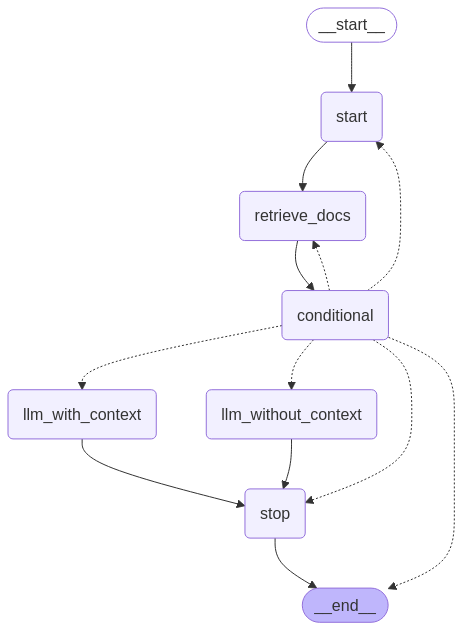

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
user_question = r"Can a patient take warfarin and aspirin together?"
initial_state = {"question": user_question, "context": "", "response": ""}
result = graph.invoke(initial_state)
print(result["response"].content)

The combination of warfarin and aspirin increases the risk of gastrointestinal bleeding, with some studies showing a rate ratio as high as 6.48 compared to using either drug alone.  However, this risk is not uniform.  Studies using low-dose aspirin (100mg daily) showed no excess risk of major bleeding.  Furthermore, in certain patient groups (e.g., those with prosthetic heart valves at high risk of thromboembolism), the benefits of concurrent use may outweigh the increased bleeding risk.  In such cases, gastroprotection (e.g., proton pump inhibitors) may be recommended.  The decision to use both medications concurrently should be made by a physician, carefully weighing the individual patient's risks and benefits.


In [ ]:
---